# HW2, Team-2 DSC291: Data transfer between S3 and EC2

### Background
Data transfer between nodes of distributed systems can become a potential bottleneck of big data applications, especially when computing resources and memory resources are not co-located. It is important to understand the performance differences that the system's interfaces afford, and the price one pays to utilize them. In this experiment, we will analyze how long it takes to transfer different loads of data from the S3 storage service to different EC2 instances and how instance pricing is related to data transfer performance. 

### Approach
We started by coming up with a notebook that runs a placeholder example script on multiple types of EC2 instances, making use of the AWS-Jupyter package (this can be found [here](https://github.com/fliphilipp/Public-DSC291/blob/master/hw2/hw2Methodsfinal.ipynb)). As four of our members had successfully set up AWS-Jupyter when we started this project, we had a Zoom meeting with one of them screen-sharing the draft notebook in the cloud. We then came up with a script that measures performance of data transfer between S2 and multiple EC2 instances, which we ran in the cloud once. The resulting data was saved in our github, and statistical analysis of the results was done locally. The final result is this Jupyter notebook presentation, which shows the results of our analysis.

### Results
We found that data transfer rates from S3 do not vary too much between a range of the EC2 instance types on the cheaper end of the spectrum (we didn't want to spend too much money!). This implies that it is most cost-effective to use the cheapest EC2 instances that fulfill the memory requirements of the task at hand, when data transfer from S3 is the main objective.


In [1]:
# enable inline graphics
%pylab inline  

# import stuff
import os
from os.path import isfile,isdir
from os import mkdir,chdir,getcwd
import pickle as pk
import pandas as pd
import numpy as np
import subprocess
from time import sleep
import argparse
from scipy.stats import sem, t
from scipy import mean

Populating the interactive namespace from numpy and matplotlib


### Distribution of hours spent
This is a rough approximation. The main point here is that we all contributed equally. 

In [2]:
hoursTotal = 43290750980934832098093  # just a rough guess
teamnames = ['Philipp Arndt', 'Morgan Levy', 'Suhan Zhong', 'Sihua Chen', 'Satyam Gaba', 'Junyan Liu', 'Jake Daly']
teamroles = ['Domain Expert, SIO PhD', 'Domain Expert, GPS Post-Doc', 'Math PhD', 'Math-CSME Masters', 
             'Treasurer, Masters CSE', 'Masters CSE', 'Masters ECE']
timespent = np.ones(len(teamnames)) * hoursTotal / len(teamnames)
workdistribution = pd.DataFrame(data={'name': teamnames, 'role': teamroles, 'work contribution': timespent})
workdistribution

,name,role,work contribution
0,Philipp Arndt,"Domain Expert, SIO PhD",6.18439e+21
1,Morgan Levy,"Domain Expert, GPS Post-Doc",6.18439e+21
2,Suhan Zhong,Math PhD,6.18439e+21
3,Sihua Chen,Math-CSME Masters,6.18439e+21
4,Satyam Gaba,"Treasurer, Masters CSE",6.18439e+21
5,Junyan Liu,Masters CSE,6.18439e+21
6,Jake Daly,Masters ECE,6.18439e+21


### Import the EC2 pricing data

In [3]:
pricedf = pd.read_csv('ec2ondemandprices20200419.csv')
if pricedf['priceHour'].dtype == 'O':
    pricedf['priceHour'] = pd.to_numeric(pricedf.priceHour.str.extract('(\d*\.?\d.?\d.?\d.)')[0])

priceCutOff = 0.5
dfTest = pricedf[pricedf['priceHour'] < priceCutOff]

typeList = dfTest['instanceType'].tolist()
priceList = np.round(dfTest['priceHour'].tolist(),4)

price_dir = {typeList[i]: priceList[i] for i in range(len(typeList))} 
pricedf.head(8)

,instanceType,vCPU,ECU,memoryGB,instanceStorage,priceHour,category
0,t3.nano,2,Variable,0.5 GiB,EBS Only,0.0062,general purpose
1,t3.micro,2,Variable,1 GiB,EBS Only,0.0125,general purpose
2,t3.small,2,Variable,2 GiB,EBS Only,0.0250,general purpose
3,t3.medium,2,Variable,4 GiB,EBS Only,0.0499,general purpose
4,t3.large,2,Variable,8 GiB,EBS Only,0.0998,general purpose
5,t3.xlarge,4,Variable,16 GiB,EBS Only,0.1997,general purpose
6,t3.2xlarge,8,Variable,32 GiB,EBS Only,0.3994,general purpose
7,m5.large,2,10,8 GiB,EBS Only,0.1150,general purpose


### Read in the experiment results and plot them
We see that execution times are somewhat faster for the more expensive instance types, yet the differences don't seem to be very large. 


----------
Results for execution time (in seconds) of transferring 1KB from S3 to EC2:

   type       mean            95.0% CI     
m5.2xlarge   0.188       ( 0.179 - 0.196 )
r5.xlarge    0.211       ( 0.199 - 0.224 )
r5d.xlarge   0.212       ( 0.197 - 0.226 )
c5.2xlarge   0.209       ( 0.199 - 0.219 )
t3.xlarge    0.216       ( 0.206 - 0.226 )
m5.xlarge    0.217       ( 0.206 - 0.228 )
c5.xlarge    0.262       ( 0.215 - 0.309 )
r5d.large    0.250       ( 0.241 - 0.259 )
 r5.large    0.252       ( 0.245 - 0.259 )
 c5.large    0.262       ( 0.242 - 0.281 )
t3.2xlarge   0.278       ( 0.247 - 0.308 )
 m5.large    0.272       ( 0.254 - 0.290 )
 t3.micro    0.277       ( 0.262 - 0.292 )
t3.medium    0.293       ( 0.265 - 0.322 )
 t3.small    0.276       ( 0.264 - 0.288 )

----------
Results for execution time (in seconds) of transferring 10KB from S3 to EC2:

   type       mean            95.0% CI     
c5.2xlarge   0.202       ( 0.189 - 0.215 )
m5.2xlarge   0.200       ( 0.191 - 0.209 )
c5

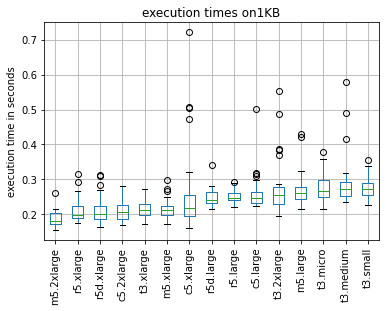

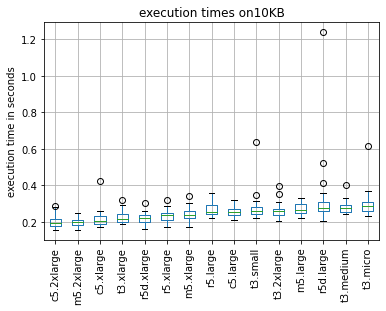

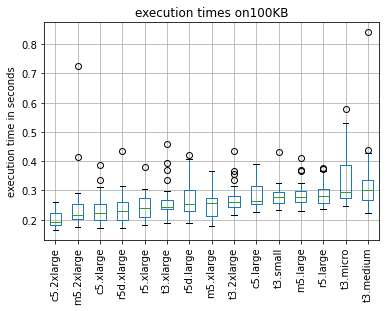

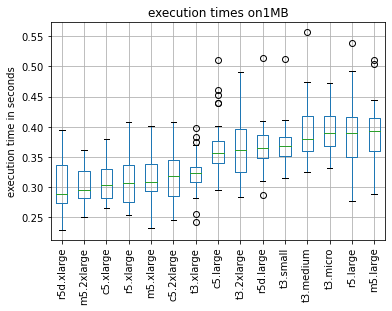

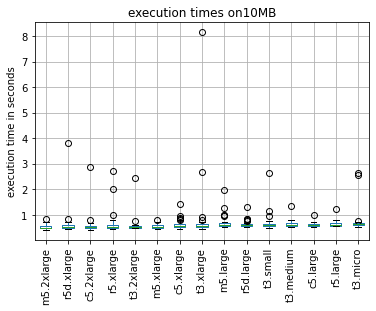

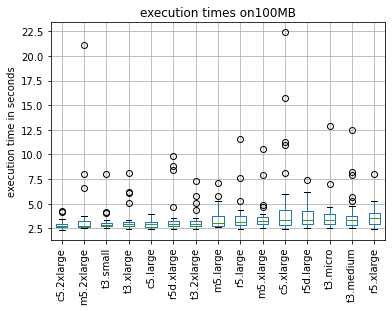

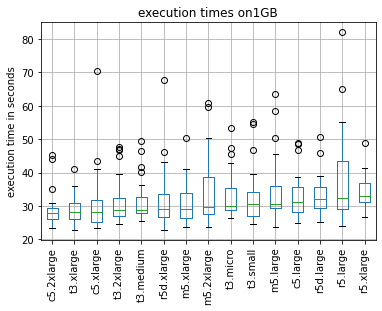

<Figure size 432x288 with 0 Axes>

In [4]:
file_names = ["1KB","10KB", "100KB", "1MB", "10MB", "100MB", "1GB"]
confidence = 0.95
for curr_col in range(7):
    ser = {}
    for i in sorted(os.listdir("latencies/")):
        df = pd.read_csv("latencies/" + i, header = None)
        ser[i[10:-4]] = df[curr_col]
    results = pd.DataFrame(ser)
    results = results[results.columns[np.argsort(results.median())]]  # sort by median execution time
    print('\n----------\nResults for execution time (in seconds) of transferring {amount} from S3 to EC2:\n'.format(amount=file_names[curr_col]))
    print('{:^10} {:^10}     {:^16} '.format('type', 'mean', '{conf}% CI'.format(conf=confidence*100)))
    for i in results.columns:
        n = len(results[i])
        thisMean = np.mean(results[i])
        std_err = sem(results[i])
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        start = thisMean - h
        end = thisMean + h
        print('{:^10} {:^10.3f}    ({:>6.3f} - {:<6.3f})'.format(i,thisMean,start,end))
    bp1 = results.boxplot(rot=90)
    bp1.set_title("execution times on" + file_names[curr_col])
    bp1.set_ylabel('execution time in seconds')
    bp1 = figure(curr_col + 2)

### Now, compute the cost statististics for each data transfer on each instance type
Now, we clearly see that when it only comes to tranferring data from S3 to EC2, **the cheapest instances are the most cost effective ones**. However, when tranferring large amounts of data, one of course needs to make sure the instance type of choice meets the memory requirements of the task at hand. 


----------
Results for cost effectiveness (in USD) of transferring 1KB from S3 to EC2:

   type         mean                   95.0% CI          
 t3.micro    0.00000096      ( 0.00000091 - 0.00000101 )
 t3.small    0.00000191      ( 0.00000183 - 0.00000200 )
t3.medium    0.00000407      ( 0.00000368 - 0.00000446 )
 c5.large    0.00000741      ( 0.00000685 - 0.00000797 )
 m5.large    0.00000869      ( 0.00000813 - 0.00000926 )
 r5.large    0.00001057      ( 0.00001028 - 0.00001085 )
r5d.large    0.00001202      ( 0.00001158 - 0.00001246 )
t3.xlarge    0.00001197      ( 0.00001140 - 0.00001253 )
c5.xlarge    0.00001485      ( 0.00001219 - 0.00001752 )
m5.xlarge    0.00001386      ( 0.00001319 - 0.00001454 )
r5.xlarge    0.00001772      ( 0.00001666 - 0.00001878 )
r5d.xlarge   0.00002034      ( 0.00001894 - 0.00002174 )
m5.2xlarge   0.00002403      ( 0.00002293 - 0.00002513 )
c5.2xlarge   0.00002372      ( 0.00002259 - 0.00002485 )
t3.2xlarge   0.00003079      ( 0.00002740 - 0.00003417 

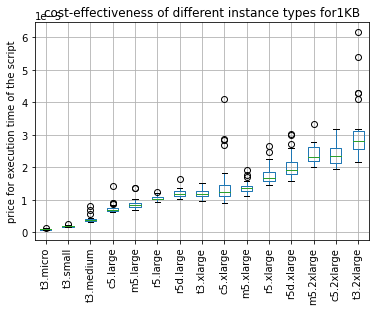

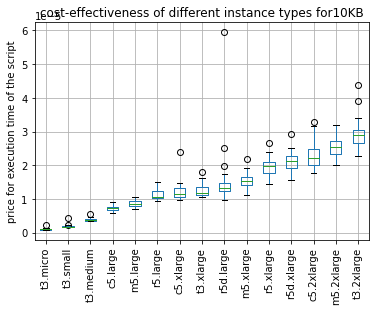

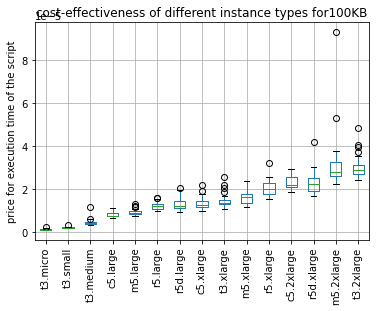

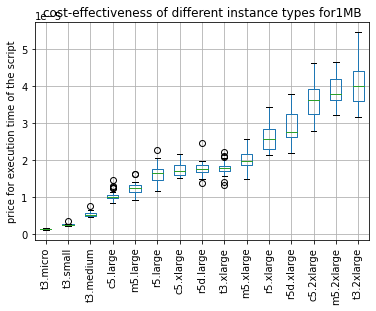

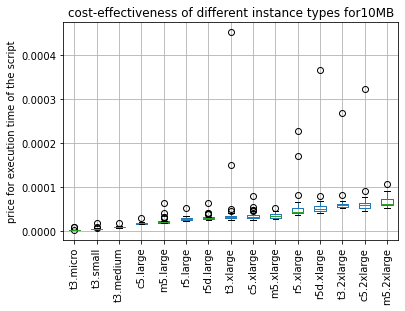

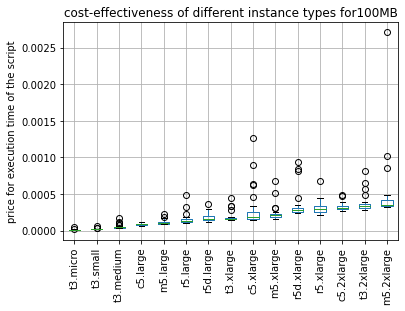

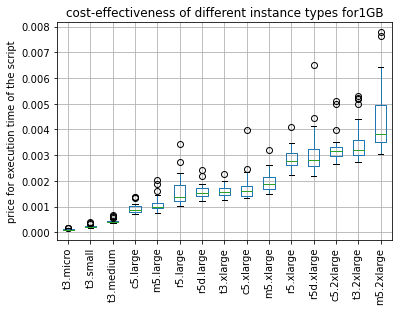

<Figure size 432x288 with 0 Axes>

In [5]:
file_names = ["1KB","10KB", "100KB", "1MB", "10MB", "100MB", "1GB"]
for curr_col in range(7):
    ser = {}
    for i in sorted(os.listdir("latencies/")):
        df = pd.read_csv("latencies/" + i, header = None)
        ser[i[10:-4]] = df[curr_col] * price_dir[i[10:-4]] / 3600
    results = pd.DataFrame(ser)
    results = results[results.columns[np.argsort(results.median())]]  # sort by median execution time
    print('\n----------\nResults for cost effectiveness (in USD) of transferring {amount} from S3 to EC2:\n'.format(amount=file_names[curr_col]))
    print('{:^10} {:^14}     {:^26} '.format('type', 'mean', '{conf}% CI'.format(conf=confidence*100)))
    for i in results.columns:
        n = len(results[i])
        thisMean = np.mean(results[i])
        std_err = sem(results[i])
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        start = thisMean - h
        end = thisMean + h
        print('{:^10} {:^14.8f}    ({:>11.8f} - {:<11.8f})'.format(i,thisMean,start,end))
    bp2 = results.boxplot(rot=90)
    bp2.set_title('cost-effectiveness of different instance types for'  + file_names[curr_col])
    bp2.set_ylabel('price for execution time of the script')
    bp2 = figure(curr_col + 2)

##### This is to convert this notebook into a set of slides, for presentation.

In [6]:
!jupyter nbconvert hw2transfers3ec2.ipynb --to slides --post serve